In [9]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import trange

import torch
from torch import nn

source = "../source"
sys.path.append(source)


from data import seq_data
from preprocessing import OneHot
from compilation import Compiler, ScalarTracker, ActivationTracker
from data_analysis.automata import to_automaton_history, reduce_automaton, to_automaton
from visualization.animation import SliderAnimation
from visualization.activations import ActivationsAnimation
from visualization.automata import AutomatonAnimation, display_automata
from visualization.epochs import EpochAnimation

from model import Model
import publication

is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [10]:
save = False

In [11]:
## Load settings
settings = "rich"

(nonlinearity, gain, lr, P, L, n_epochs, max_seq_len) = (
    pd.read_csv("model settings/rnn.txt", sep=" ", header=0).loc[settings].to_numpy()
)
P, L, n_epochs, max_seq_len = int(P), int(L), int(n_epochs), int(max_seq_len)

In [12]:
## Generate data

# Define problem and data encoding
symbols = [0, 1]
encoding = OneHot(symbols)
problem = lambda seq: np.sum(seq) % 2  # XOR problem
# problem = lambda seq: (np.sum(seq) % 3) % 2

# Define sequence lengths for training and validation datasets
train_seq_lengths = list(range(1, max_seq_len + 1))
# analysis_seq_lengths = [1, 2, 3, 4, 5, 6, 7, 8]
analysis_seq_lengths = train_seq_lengths
val_seq_length = 5
val_datapoints = 10

# Generate datasets
training_datasets = [
    seq_data(device, problem, encoding, seq_len=length) for length in train_seq_lengths
]
validation_datasets = [
    seq_data(
        device, problem, encoding, n_datapoints=val_datapoints, seq_len=val_seq_length
    )
]
analysis_data = [
    seq_data(device, problem, encoding, seq_len=length)
    for length in analysis_seq_lengths
]
tracked_datasets = validation_datasets + analysis_data + training_datasets

In [13]:
## Instantiate model
model = Model(
    encoding=encoding,
    input_size=2,
    output_size=2,
    hidden_dim=P,
    n_layers=L,
    device=device,
    nonlinearity=nonlinearity,
    gain=gain,
)

In [32]:
## Setup compiler
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, amsgrad=True, weight_decay=0.01)
compiler = Compiler(model, criterion, optimizer)
initial_hidden = model.init_hidden(batch_size=1)[-1]
compiler.trackers = {
    "loss": ScalarTracker(lambda: compiler.validation(tracked_datasets)),
    "hidden": ActivationTracker(
        encoding,
        lambda inputs: model(inputs)[1][-1],
        analysis_data,
        initial=lambda: initial_hidden,
    ),
    "output": ActivationTracker(
        encoding, lambda inputs: model(inputs)[0], analysis_data
    ),
}

In [33]:
## Training run
compiler.training_run(
    training_datasets,
    n_epochs=n_epochs,
    batch_size=128,
)

Training:  74%|███████▍  | 745/1000 [00:16<00:05, 44.17steps/s, train_loss=0.24824, val_loss=0.24520]


KeyboardInterrupt: 

Computing automata: 100%|██████████| 3000/3000 [00:05<00:00, 590.05it/s]
/home/loek/projects/rnn_structure/parity/../source/visualization/epochs.py:51: RuntimeWarning: invalid value encountered in divide
  data_normalized = (data - np.min(data)) / (np.max(data) - np.min(data))


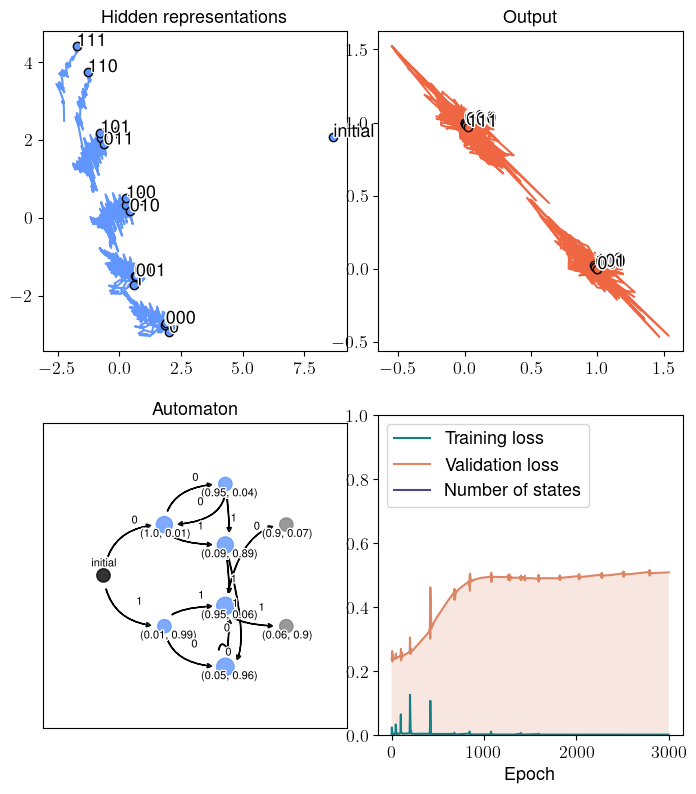

interactive(children=(SelectionSlider(description='Epoch:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,…

In [31]:
## Visualize automaton dynamics

# Filter and process data for visualization
data_hid = compiler.trackers["hidden"].get_trace()
data_output = compiler.trackers["output"].get_trace()
query = "(Dataset < 10) "
data_hid = data_hid.query(query).copy()
data_output = data_output.query(query).copy()

epochs = list(set(data_hid.index.get_level_values("Epoch")))
epochs.sort()

std = float(np.linalg.norm(data_hid.std()))
n_points = len(data_hid.query("Epoch == 0"))

automaton_history = to_automaton_history(
    data_hid, data_output, merge_distance=0.5 * std
)
loss = compiler.trackers["loss"].get_trace()
val_loss = loss.query("Dataset==0")[0].to_numpy()
train_loss = loss.query("Dataset>0").groupby("Epoch").mean()
n_states = np.array([len(automaton.states) for automaton in automaton_history])

# Create animation
publication.set_color_mixed()
animation = SliderAnimation(
    {
        "Hidden representations": ActivationsAnimation(
            data_hid, transform="PCA", colors=[5] * n_points
        ),
        "Output": ActivationsAnimation(
            data_output,
            transform="none",
            fixed_points=encoding.encoding,
            colors=[6] * n_points,
        ),
        "Automaton": AutomatonAnimation(automaton_history, reduce_automata=False),
        "Loss": EpochAnimation(
            graphs={
                "Training loss": train_loss,
                "Validation loss": val_loss,
            },
            unitless_graphs={
                "Number of states": n_states,
            },
            y_bounds=(0, 1),
        ),
    },
    parameters=epochs,
    parameter_name="Epoch",
    fig_size=4,
)

# Optionally export the animation
if save:
    animation.to_gif(f"plots/automaton_dynamics_{settings}")

100%|██████████| 100/100 [00:00<00:00, 154.52it/s]


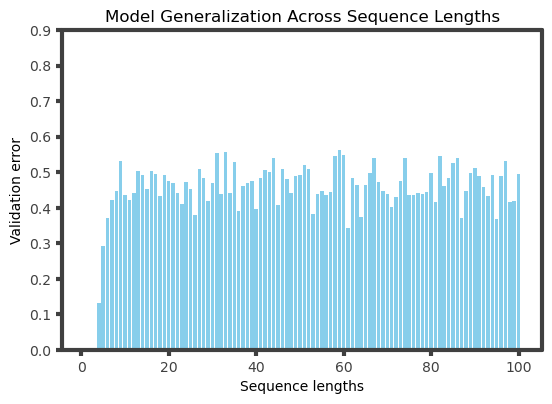

In [17]:
## Check for large sequence length generalization

# Evaluate model generalization for sequences of varying lengths
N = 100
val_data = []
for n in trange(1, N + 1):
    val_data.append(seq_data(device, problem, encoding, n_datapoints=100, seq_len=n))
val_err = compiler.validation(val_data).to_numpy()[:, 0]

# Visualize validation error for varying sequence lengths
publication.set_color_mixed()
fig = plt.figure(figsize=(6, 4))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.bar(np.arange(1, N + 1), val_err, color="skyblue")
ax.set_xlabel("Sequence lengths")
ax.set_ylabel("Validation error")
ax.set_title("Model Generalization Across Sequence Lengths")
ax.set_yticks(np.arange(0, 1, 0.1))
if save:
    publication.pub_show(save_path=f"plots/validation_error_{settings}")
else:
    publication.pub_show()

In [18]:
from activations import get_activations


datasets = training_datasets
model
encoding

data_hid = get_activations(datasets, lambda inputs: model(inputs)[1][-1], encoding)
data_output = get_activations(datasets, lambda inputs: model(inputs)[0], encoding)
std = float(np.linalg.norm(data_hid.std()))

## Add epoch index
data_hid_0 = data_hid.copy()
index = data_hid_0.index.to_frame()
index["Epoch"] = 0
index = index[["Epoch", "Dataset", "Input"]]
data_hid_0.index = pd.MultiIndex.from_frame(index)

data_hid_1 = data_hid.copy()
index = data_hid_1.index.to_frame()
index["Epoch"] = 1
index = index[["Epoch", "Dataset", "Input"]]
data_hid_1.index = pd.MultiIndex.from_frame(index)

data_hid = pd.concat([data_hid_0, data_hid_1])

data_output_0 = data_hid.copy()
index = data_output_0.index.to_frame()
index["Epoch"] = 0
index = index[["Epoch", "Dataset", "Input"]]
data_output_0.index = pd.MultiIndex.from_frame(index)

data_output_1 = data_hid.copy()
index = data_output_1.index.to_frame()
index["Epoch"] = 1
index = index[["Epoch", "Dataset", "Input"]]
data_output_1.index = pd.MultiIndex.from_frame(index)

data_output = pd.concat([data_output_0, data_output_1])


automaton = to_automaton_history(
    data_hid,
    data_output,
    merge_distance=0.5 * std,
)

Computing automata: 100%|██████████| 2/2 [00:00<00:00, 322.03it/s]


In [19]:
automaton = to_automaton(model, datasets, initial_hidden)

TypeError: to_automaton() missing 2 required positional arguments: 'datasets' and 'encoding'

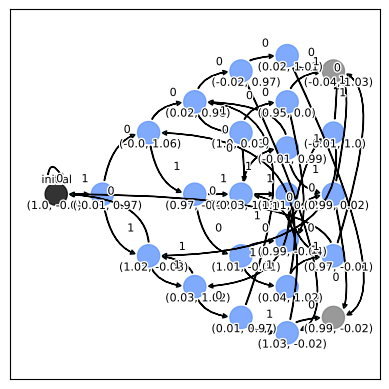

In [ ]:
display_automata(reduce_automaton(automaton))

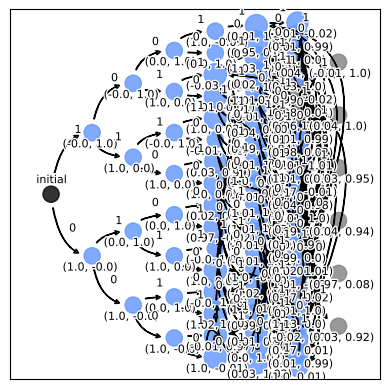

In [ ]:
display_automata(automaton)